In [1]:
import sys
import os
from argparse import Namespace
import yaml
import torch

from runners.diffusion import Diffusion, get_beta_schedule
from models.diffusion import Model
from functions.denoising import generalized_steps, compute_alpha
from main import parse_args_and_config, dict2namespace

In [2]:
with open(os.path.join("configs", "celeba.yml"), "r") as f:
    config = yaml.safe_load(f)
config = dict2namespace(config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
states = torch.load("ckpt.pth")

In [4]:
model = Model(config)
# model.load_state_dict(torch.load("ckpt.pth"))

# print(type(loaded[2]))
model = model.to(device)
model = torch.nn.DataParallel(model)
model.load_state_dict(states[0], strict=True)

/cluster/home/williad/.local/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


<All keys matched successfully>

In [36]:
betas = betas = get_beta_schedule(
            beta_schedule=config.diffusion.beta_schedule,
            beta_start=config.diffusion.beta_start,
            beta_end=config.diffusion.beta_end,
            num_diffusion_timesteps=config.diffusion.num_diffusion_timesteps,
        )
betas = torch.from_numpy(betas).float().to(device)

In [37]:
start_noise = torch.randn(1, 3, 64, 64).to(device)

In [38]:
x = start_noise.clone()
seq = torch.arange(1000).tolist()[::100]
xs = generalized_steps(x, seq, model, betas, eta=0)

900 800
800 700
700 600
600 500
500 400
400 300
300 200
200 100
100 0
0 -1
tensor([[[[0.0001]]]], device='cuda:0')
tensor([[[[0.]]]], device='cuda:0')


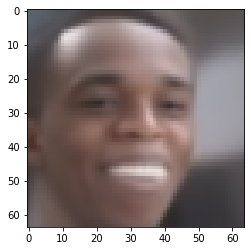

In [39]:
import matplotlib.pyplot as plt
instance = xs[0][-1]
plt.imshow((instance.cpu().permute(0, 2, 3, 1)[0] + 1)/2)

In [40]:
beta_test = torch.cat([torch.zeros(1).to(betas.device), betas], dim=0)
print(betas.shape)
print(beta_test)
print(beta_test.shape)
alphabar_test = torch.cumprod(1-beta_test, dim=0).to(device)
eta = 0

test = compute_alpha(betas, torch.LongTensor([0]).to(device))
print(test)
print(alphabar_test.index_select(0, torch.LongTensor([0+1]).to(device)))

test_prev = compute_alpha(betas, torch.LongTensor([-1]).to(device))
print(test_prev)
print(alphabar_test.index_select(0, torch.LongTensor([-1+1]).to(device)))

print("")
alphabar = torch.cumprod(1-betas, dim=0)
print("First ten")
print(alphabar[0:10])
print(alphabar_test[0:10])
print("Last twenty")
print(alphabar[-20:])
print(alphabar_test[-20:])
print(len(alphabar))
print(len(alphabar_test))

torch.Size([1000])
tensor([    0.0000,     0.0001,     0.0001,  ...,     0.0200,     0.0200,
            0.0200], device='cuda:0')
torch.Size([1001])
tensor([[[[0.9999]]]], device='cuda:0')
tensor([0.9999], device='cuda:0')
tensor([[[[1.]]]], device='cuda:0')
tensor([1.], device='cuda:0')

First ten
tensor([0.9999, 0.9998, 0.9996, 0.9995, 0.9993, 0.9991, 0.9989, 0.9986, 0.9984,
        0.9981], device='cuda:0')
tensor([1.0000, 0.9999, 0.9998, 0.9996, 0.9995, 0.9993, 0.9991, 0.9989, 0.9986,
        0.9984], device='cuda:0')
Last twenty
tensor([    0.0001,     0.0001,     0.0001,     0.0001,     0.0001,     0.0001,
            0.0001,     0.0001,     0.0001,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000], device='cuda:0')
tensor([    0.0001,     0.0001,     0.0001,     0.0001,     0.0001,     0.0001,
            0.0001,     0.0001,     0.0001,     0.0000,     0.0000,     0.0000,
         

In [41]:
x = start_noise.clone()
step_size = 100
with torch.no_grad():
    for i in range(1000-step_size, -1, -step_size):
        t = i + 1
        prev_t = t - step_size
        if t < step_size: prev_t = 0
        print(t, prev_t)
        
        tt = torch.LongTensor([t] * x.shape[0]).to(x.device)
        z = torch.randn(x.shape).to(x.device) if t > 1 else 0
        eps = model(x, tt)

        x0_t = (x - eps * (1 - alphabar[t]).sqrt()) / alphabar[t].sqrt()
#         x0_t = ddim.get_predicted_x0(x, t)
        

        c1 = eta * ((1 - alphabar[t] / alphabar[prev_t]) * (1 - alphabar[prev_t]) / (
            1 - alphabar[t])).sqrt()
        c2 = ((1 - alphabar[prev_t]) - c1 ** 2).sqrt()
        
        x = alphabar[prev_t].sqrt() * x0_t + c1 * z + c2 * eps
        if t < step_size:
            print(1 - alphabar[t] / alphabar[prev_t])
            print((1 - alphabar[prev_t]) / (
            1 - alphabar[t]))
#         print(x[0, 0, 0, 0], t, prev_t)
        
        

901 801
801 701
701 601
601 501
501 401
401 301
301 201
201 101
101 1
1 0
tensor(0.0001, device='cuda:0')
tensor(0.4547, device='cuda:0')


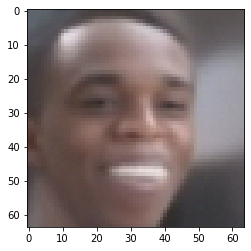

In [42]:
plt.imshow((x.cpu().permute(0, 2, 3, 1)[0] + 1)/2)

Notes:
Start from t = diffusionsteps - step size
When calculating alphabar, add 0 to start of beta?????? and sample from it one timestep ahead???